# 1D Heat conduction for extruded surface example 2

The engine cylinder of a motorcycle is constructed of 2024-T6 aluminum alloy and is of height
H=0.15 m and outside diameter D  50 mm. Under typical operating conditions the outer surface of
the cylinder is at a temperature of 500 K and is exposed to ambient air at 300 K, with a
convection coefficient of 50 W/m2K. Annular fins are integrally cast with the cylinder to
increase heat transfer to the surroundings. Consider five such fins, which are of thickness t=6
mm, length L  20 mm, and equally spaced. What is the increase in heat transfer due to use of the
 fins?
![EngineCylidnerWithFins](images/EngineCylinderWithFins.png)

## Known

In [1]:
height = 0.15 #m
outer_diameter = 0.05 # m
temperature_surface = 500 # K
temperature_air = 300 # K
thickness_fin = 0.006 #
length_fin = 0.020 # m

## Find
Increase in heat transfer due to use of the fins. We will find the increase in heat transfer per fin. 

## Schematics
For each fin, we can find a function for $A_c$ and $A_s$ as a function of r.

![CircularFin](images/CircularFin.svg)

$$A_s(r) = 2 * \pi \left(r^2 - r_i^2\right)$$
$$A_c(r) = 2 \pi t r $$

## Assumption
- Steady state
- Uniform and constant thermal conductivity and convection coefficient.

## Properties

In [2]:
thermal_conductivity = 186 # W/mK
convection_coefficient = 50 # W/m2K

## Analysis
We will solve 
$$\frac{d^2T}{dr^2} + \left(\frac{1}{A_c}\frac{dA_c}{dr}\right)\frac{dT}{dr} - \left(\frac{1}{A_c}\frac{1}{k}\frac{dA_s}{dr}\right)\left(T - T_\infty\right)=0$$
and find 
$$q_f = -kA_c\frac{dT}{dr}\biggr\rvert_{r=r_1}$$

We will reformulate the differential equation to first order by having $x_1 = T$ and $x_2 = \frac{dx_1}{dr}$. Then

$$
\left[
    \begin{array} \\
        \frac{dx_1}{dr} \\
        \frac{dx_2}{dr}
    \end{array}
\right]=
\left[
    \begin{array} \\
        x_2 \\
        -\left(\frac{1}{A_c}\frac{dA_c}{dr}\right)x_2 + \left(\frac{1}{A_c}\frac{h}{k}\frac{dA_s}{dr}\right)\left(x_1 - T_\infty\right)
    \end{array}
\right]
$$

This is a ODE in a vector form. Our boundary condition is 
$$x_1(r_1) = T_b$$
$$x_2(r_2) = -\frac{h}{k}\left(x_1(r_2) - T_\infty\right)$$

For this problem, we can use a solver for the boundary condition, `solve_bvp` from `scipy.integrate`. 

Heat transfer with fin is 102.703 W, compared to 9.425 W without
Fin effectivene: 10.897115408954814
Fin efficiency: 0.978782821163606


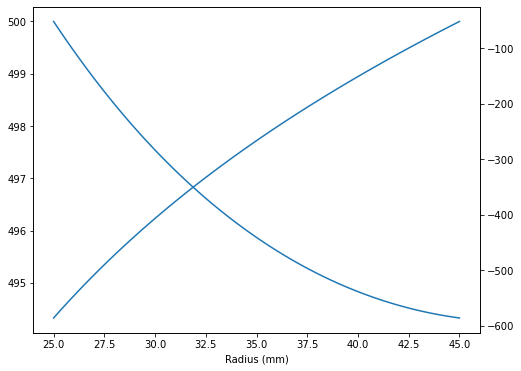

In [3]:
import numpy as np
from scipy.optimize import root
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
# First define area functions and their derivatives.
def get_area_surrounding(radius):
    return 2 * np.pi * (radius**2 - (outer_diameter/2)**2)

def get_area_surrounding_derivative(radius):
    return 4 * np.pi * radius

def get_area_crosssection(radius):
    return 2 * np.pi * radius * thickness_fin

def get_area_crosssection_derivative(radius):
    return 2 * np.pi * thickness_fin

# We can now define the ODE function to solve
def ode_to_solve(radius, x):
    x1 = x[0]
    x2 = x[1]
    dx1 = x2
    dx2 = -1 / get_area_crosssection(radius) * get_area_crosssection_derivative(radius) * x2 \
        + 1 / get_area_crosssection(radius) * convection_coefficient / thermal_conductivity * \
        get_area_surrounding_derivative(radius) * (x1 - temperature_air)
    return np.vstack((dx1, dx2))

# We need to set the boundary condition as a residual of the function
def boundary_condition(xa, xb):
    residual_a = xa[0] - temperature_surface
    residual_b = xb[1] + convection_coefficient / thermal_conductivity * (xb[0] - temperature_air)
    return np.array([residual_a, residual_b])

# Solve the equation
initial_number_mesh = 10
initial_mesh_for_r = np.linspace(
    outer_diameter / 2, outer_diameter/2 + length_fin, initial_number_mesh)
initial_guesses = np.vstack((
    np.linspace(temperature_surface, temperature_air, initial_number_mesh),
    np.ones(initial_number_mesh)*(temperature_air - temperature_surface) / length_fin
))
solution = solve_bvp(ode_to_solve, boundary_condition, initial_mesh_for_r, initial_guesses)

if solution.success:
    fig, ax = plt.subplots(figsize=(8, 6))
    radius_array_to_plot = np.linspace(outer_diameter / 2, outer_diameter / 2 + length_fin, 101)
    ax.plot(radius_array_to_plot * 1000, solution.sol(radius_array_to_plot)[0])
    ax.set_xlabel('Radius (mm)')
    ax1 = ax.twinx()
    ax1.plot(radius_array_to_plot * 1000, solution.sol(radius_array_to_plot)[1])

area_base = np.pi * outer_diameter * thickness_fin
heat_loss_with_fin = - thermal_conductivity * area_base * solution.y[1][0]
heat_loss_without_fin = convection_coefficient * area_base * (temperature_surface - temperature_air)
print(f'Heat transfer with fin is {heat_loss_with_fin:.3f} W, '
      f'compared to {heat_loss_without_fin:.3f} W without')
fin_effectiveness = heat_loss_with_fin / heat_loss_without_fin
r_at_the_tip = outer_diameter / 2 + length_fin
area_fin = get_area_surrounding(r_at_the_tip) + get_area_crosssection(r_at_the_tip)
fin_efficiency = heat_loss_with_fin / \
                 (convection_coefficient * area_fin * (temperature_surface - temperature_air))
print(f'Fin effectivene: {fin_effectiveness}')
print(f'Fin efficiency: {fin_efficiency}')